Abel transform
1. Import .tiff image

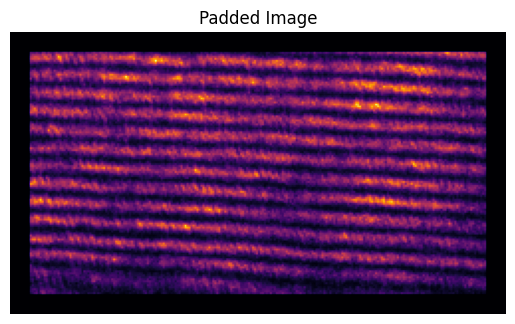

In [37]:
import matplotlib.pyplot as plt
import tifffile as tiff # Loads .tiff as a NumPy array
import numpy as np # low level image manipulation (matrix)

# load imgae: # reference_image_X1.tif
img = tiff.imread("reference_image_X1.tif")  
# crop image
img_crop = img[116:238, 289:519] 
# padding image
img_padded = np.pad(img_crop, pad_width = 10, mode = 'constant') # constant, wrap, symmetric

# Display the padded image
plt.imshow(img_padded, cmap='inferno') # cmap='cividis', 'viridis', 'inferno', 'magma', 'plasma'
plt.title("Padded Image")
plt.axis('off')
plt.show()

2. Fourier transform

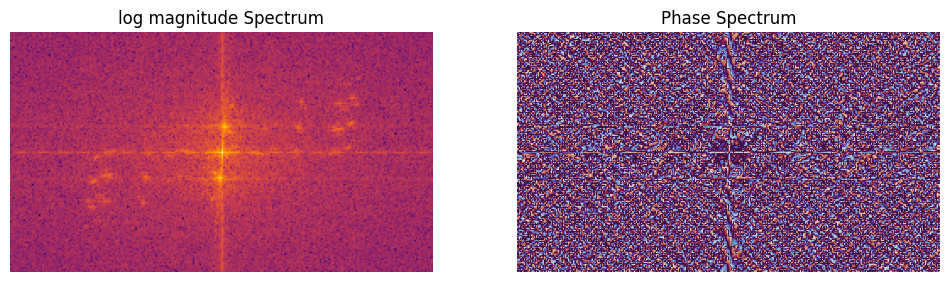

In [38]:
# Compute the FFT and shift the zero frequency component to the center
fft_image = np.fft.fft2(img_padded)
fft_shifted = np.fft.fftshift(fft_image)
# magnitude spectrum |fft_shifted| - (log-scaled for visibility)
magnitude_spectrum = np.log1p(np.abs(fft_shifted))
# magnitude_spectrum = np.abs(fft_shifted)
# phase spectrum angle(fft_shifted)
phase_spectrum = np.angle(fft_shifted)

# Plot both magnitude and phase spectra
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(magnitude_spectrum, cmap='inferno')
ax[0].set_title("log magnitude Spectrum")
ax[0].axis('off')
ax[1].imshow(phase_spectrum, cmap='twilight') # symetrie neg a pos hodnot, smooth cyclic transition, better visibility of subtle phase variations
ax[1].set_title("Phase Spectrum")
ax[1].axis('off')
plt.show()

3. Filtration of 1st diffraction order

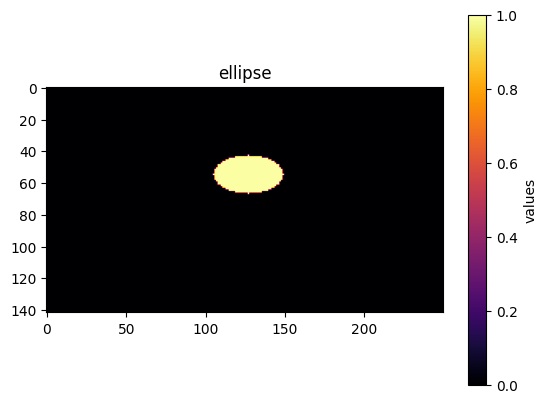

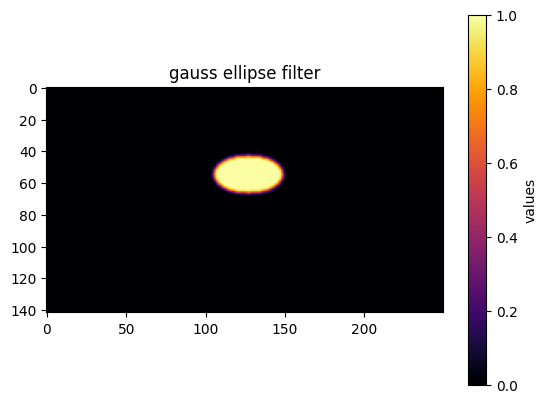

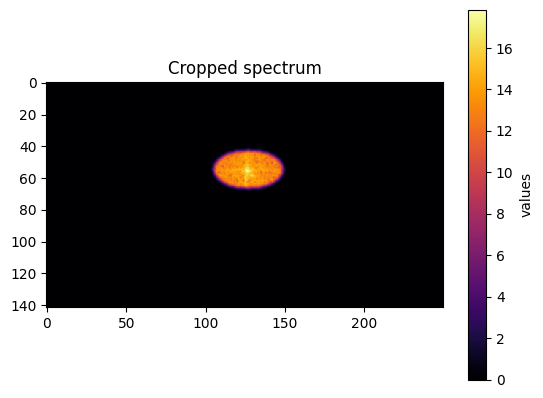

In [44]:
from scipy.ndimage import gaussian_filter
# create elliptical gaussian filter placed in [x, y] coordinate
# 1) make a manual selection on click
# 2) try to automate it -> not important

# Define the new shift values
# X_do, Y_do = 5, -20  # move to the right from center by 30 px, up from center by 50 px
X_do, Y_do = 2, -16
# Get Fourier center
rows, cols = magnitude_spectrum.shape
y_center, x_center = rows // 2, cols // 2 # rounded "floor" division operator
# Apply the shift to the Fourier center
shifted_peak_x = x_center + X_do
shifted_peak_y = y_center + Y_do

## --- create elliptical gaussian mask ---
# Define the elliptical mask centered at the shifted location
a, b = cols // 11, rows // 11 # Semi-axes of the ellipse
# Create a coordinate 1D array...meshgrid
y, x = np.ogrid[:rows, :cols] # y = vektor hodnot 0 až 144 (výška obr), x = vektor hodnot 0 až 250 (šířka obr), 

# Define the elliptical mask equation at the new location
ellipse_mask = (((x - shifted_peak_x) / a) ** 2 + ((y - shifted_peak_y) / b) ** 2) <= 1

plt.imshow(ellipse_mask, cmap='inferno')
plt.title("ellipse")
plt.colorbar(label="values")
plt.show()
# Generate a Gaussian fade-out mask at the new location
gaussian_fade = np.zeros_like(ellipse_mask, dtype=float) # zeros matrix with the size of ellipse_mask
gaussian_fade[ellipse_mask] = 1
gaussian_fade = gaussian_filter(gaussian_fade, sigma=1)  # Smooth transition

plt.imshow(gaussian_fade, cmap='inferno')
plt.title("gauss ellipse filter")
plt.colorbar(label="values")
plt.show()
# Filter on magnitude spectrum check
crop_magnitude = magnitude_spectrum * gaussian_fade
plt.imshow(crop_magnitude, cmap='inferno')
plt.title("Cropped spectrum")
plt.colorbar(label="values")
plt.show()


4. EXTRACT PHASE IMAGE

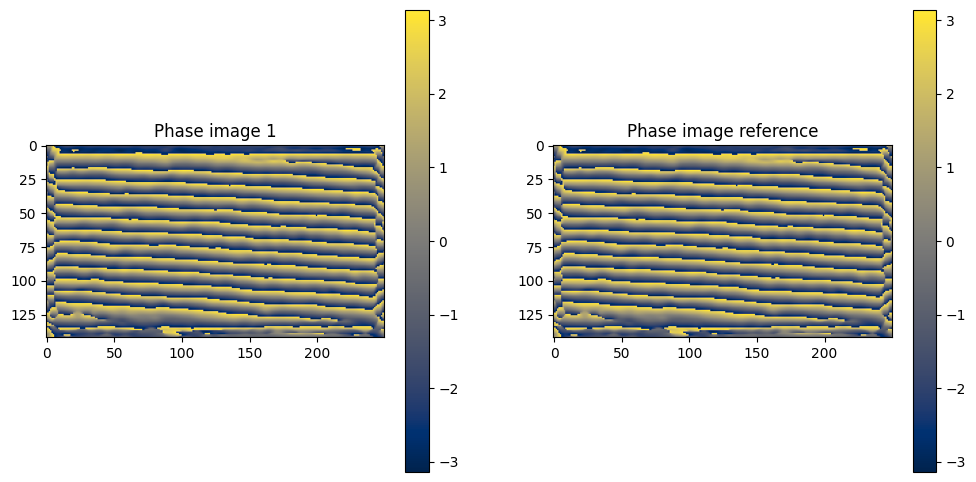

In [45]:
# Apply the shifted mask to the Fourier spectrum
filtered_fft = fft_shifted * gaussian_fade
# Compute the inverse FFT
ifft_shifted = np.fft.ifftshift(filtered_fft)
reconstructed_image = np.fft.ifft2(ifft_shifted)
phase_im = np.angle(reconstructed_image)  # Extract phase

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
im1 = ax[0].imshow(phase_im, cmap='cividis')
ax[0].set_title("Phase image 1")
fig.colorbar(im1, ax=ax[0])
ax[1].imshow(phase_im, cmap='cividis')
ax[1].set_title("Phase image reference")
fig.colorbar(im1, ax=ax[1])
plt.show()

5. PHASE SHIFT IMAGE

In [ ]:
phase_shift = phase_im_r - phase_im

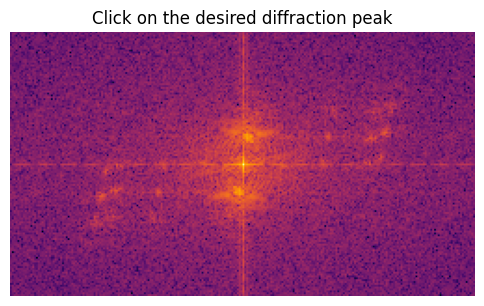

In [17]:
from scipy.ndimage import gaussian_filter
# create elliptical gaussian filter placed in [x, y] coordinate
# 1) make a manual selection on click
# 2) try to automate it -> not important

# Define the new shift values
X_do, Y_do = 30, -50  # move to the right from center by 30 px, up from center by 50 px

# Get Fourier center
rows, cols = magnitude_spectrum.shape
y_center, x_center = rows // 2, cols // 2 # rounded "floor" division operator
# Apply the shift to the Fourier center
shifted_peak_x = x_center + X_do
shifted_peak_y = y_center + Y_do

# magnitude_spectrum
# Function to capture click event
clicked_coords = []
def onclick(event):
    global clicked_coords
    x_click, y_click = int(event.xdata), int(event.ydata)
    X_do = x_click - x_center
    Y_do = y_click - y_center
    print(f"Selected coordinates: ({x_click}, {y_click})")
    print(f"Shift values (X_do, Y_do): ({X_do}, {Y_do})")
    plt.close()

# Display the Fourier magnitude spectrum
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(magnitude_spectrum, cmap='inferno')
ax.set_title("Click on the desired diffraction peak")
ax.axis('off')

# Connect the click event
fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()